## Short example of the advantage of iDQN over DQN

### Define the environment

In [33]:
from idqn.environments.lqr import LinearQuadraticEnv
import numpy as np

env = LinearQuadraticEnv(A=0.8, B=-0.9, Q=-0.5, R=-0.5, S=0.2)
print("P:", env.P)
print("Optimal M:", env.optimal_weights[2], "Optimal G:", env.optimal_weights[0])
max_g = np.abs(env.optimal_weights[0] / 2)
min_m = 2 * env.optimal_weights[2]  # always negative
initial_point = np.array([0.5 * env.optimal_weights[2], -max_g / 2])

Transition: s' = As + Ba
Transition: s' = 0.8s + -0.9a
Reward: Qs² + 2 Ssa + Ra²
Reward: -0.5s² + 0.4sa + -0.5a²
P: -0.47176912283546646
Optimal M: -0.882133 Optimal G: -0.8019322


### Compute the optimal itertaions

In [34]:
def optimal_bellman_iteration(point):
    return np.array([env.R + env.B ** 2 * point[1], env.Q + env.A ** 2 * point[1]])

def projection(point):
    return np.array([min(point[0], 0), np.clip(point[1], -max_g, max_g)])

def bellman_line(m):
    return env.Q - env.R * env.A ** 2 / env.B ** 2 + env.A ** 2 / env.B ** 2 * m

### Run DQN and iDQN (offline)

In [35]:
import jax
import jax.numpy as jnp

def Q(params, s, a):
    return params["G"] * s ** 2 + params["M"] * a ** 2

def loss_dqn(params, target_params, batch_s, batch_a):
    prediction = Q(params, batch_s, batch_a)

    batch_s_prime = env.A * batch_s + env.B * batch_a
    batch_reward = env.Q * batch_s ** 2 + 2 * env.S * batch_s * batch_a + env.R * batch_a ** 2
    target = batch_reward + target_params["G"] * batch_s_prime ** 2

    return jnp.square(prediction - target).mean()

def loss_idqn(params, target_params, batch_s, batch_a):
    return loss_dqn(params["params_1"], target_params["params_0"], batch_s, batch_a) + loss_dqn(params["params_2"], target_params["params_1"], batch_s, batch_a)


gradient_steps = 30
lr = 0.05
samples = jnp.linspace(0, jnp.pi, 10)
batch_s = jnp.cos(samples)
batch_a = jnp.sin(samples)
dqn_params = {"M": initial_point[0], "G": initial_point[1]}
target_dqn_params = {"M": initial_point[0], "G": initial_point[1]}
idqn_params = {"params_0": dqn_params, "params_1": dqn_params, "params_2": dqn_params}
target_idqn_params = {"params_0": dqn_params, "params_1": dqn_params, "params_2": dqn_params}

project_params = lambda params: {"M": min(params["M"], 0), "G": np.clip(params["G"], -max_g, max_g)}

for g in range(gradient_steps):
    grad_dqn = jax.grad(loss_dqn)(dqn_params, target_dqn_params, batch_s, batch_a)
    dqn_params = jax.tree_map(lambda x, y: x - lr * y, dqn_params, grad_dqn)
    dqn_params = project_params(dqn_params)
    
    grad_idqn = jax.grad(loss_idqn)(idqn_params, target_idqn_params, batch_s, batch_a)
    idqn_params = jax.tree_map(lambda x, y: x - lr * y, idqn_params, grad_idqn)
    idqn_params["params_0"] = project_params(idqn_params["params_0"])
    idqn_params["params_1"] = project_params(idqn_params["params_1"])
    idqn_params["params_2"] = project_params(idqn_params["params_2"])
    target_idqn_params = idqn_params  # update the target parameters

extract_point = lambda params: np.array([params["M"], params["G"]])
dqn_point = extract_point(dqn_params)
idqn_point_1 = extract_point(idqn_params["params_1"])
idqn_point_2 = extract_point(idqn_params["params_2"])

### Plot results of DQN and iDQN

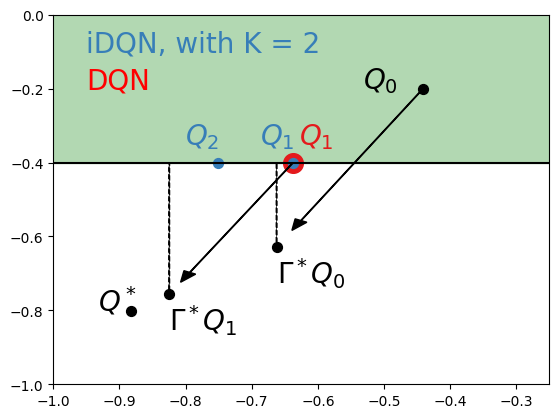

In [36]:
import matplotlib.pyplot as plt

dqn_color = "#e41a1c"
idqn_color = "#377eb8"

n_points = 10
ms = np.linspace(min_m, 0, n_points)

# Optimal point
plt.scatter(env.optimal_weights[2], env.optimal_weights[0], color="black", s=50)
plt.text(-0.05 + env.optimal_weights[2], env.optimal_weights[0], "$Q^*$", fontsize=20)

# Allowed parameter space
plt.plot(ms, np.ones(n_points) * max_g, color="black")
plt.plot(ms, -np.ones(n_points) * max_g, color="black")
plt.fill_between(ms, -np.ones(n_points) * max_g, np.ones(n_points) * max_g, color="green", alpha=0.3)
plt.vlines(0, ymin=-max_g, ymax=max_g, color="black")

# Plot the first Bellman iteration and its projection
plt.scatter(initial_point[0], initial_point[1], color="black", s=50)
plt.text(-0.09 + initial_point[0], initial_point[1], "$Q_0$", fontsize=20)
x, y = initial_point[0], initial_point[1]
first_iteration = optimal_bellman_iteration(initial_point)
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx / 1.2, dy / 1.2, head_width = 0.02, color="black")

plt.scatter(first_iteration[0], first_iteration[1], color="black", s=50)
plt.text(first_iteration[0], -0.1 + first_iteration[1], f"$\Gamma^*Q_0$", fontsize=20)

first_projection = projection(first_iteration)
x, y = first_projection[0], first_projection[1]
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx, dy, color="black", linestyle="dashed")

# Plot DQN point
plt.scatter(dqn_point[0], dqn_point[1], color=dqn_color, s=200)
plt.text(0.01 + dqn_point[0], 0.05 + dqn_point[1], "$Q_1$", color=dqn_color, fontsize=20)

# Plot the first iDQN point
plt.scatter(idqn_point_1[0], idqn_point_1[1], color=idqn_color, s=50)
plt.text(-0.05 + idqn_point_1[0], 0.05 + idqn_point_1[1], "$Q_1$", color=idqn_color, fontsize=20)

# Plot the second Bellman iteration and its projection from the first iDQN point
x, y = idqn_point_1[0], idqn_point_1[1]
second_iteration = optimal_bellman_iteration(idqn_point_1)
dx, dy = second_iteration[0] - x, second_iteration[1] - y
plt.arrow(x, y, dx / 1.2, dy / 1.2, head_width = 0.02, color="black")

plt.scatter(second_iteration[0], second_iteration[1], color="black", s=50)
plt.text(second_iteration[0], -0.03 + second_iteration[0], f"$\Gamma^*Q_1$", fontsize=20)

second_projection = projection(second_iteration)
x, y = second_projection[0], second_projection[1]
dx, dy = second_iteration[0] - x, second_iteration[1] - y
plt.arrow(x, y, dx, dy, color="black", linestyle="dashed")

plt.scatter(idqn_point_2[0], idqn_point_2[1], color=idqn_color, s=50)
plt.text(-0.05 + idqn_point_2[0], 0.05 + idqn_point_2[1], "$Q_2$", color=idqn_color, fontsize=20)

plt.text(-0.95, -0.2, "DQN", color="red", fontsize=20)
plt.text(-0.95, -0.1, "iDQN, with K = 2", color=idqn_color, fontsize=20)

plt.xlim(-1, -0.25)
plt.ylim(-1, 0)
plt.savefig("pratical_example.pdf", bbox_inches='tight')

### Plot only DQN

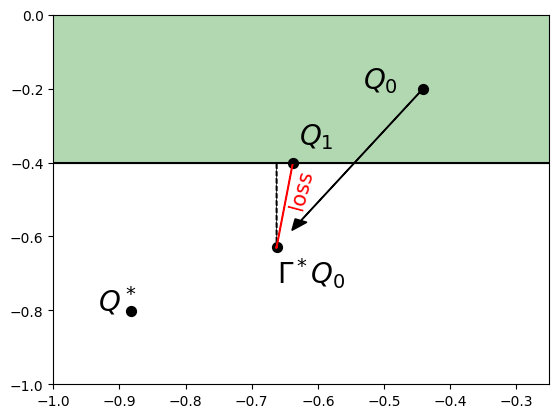

In [37]:
import matplotlib.pyplot as plt

n_points = 10
ms = np.linspace(min_m, 0, n_points)

# Optimal point
plt.scatter(env.optimal_weights[2], env.optimal_weights[0], color="black", s=50)
plt.text(-0.05 + env.optimal_weights[2], env.optimal_weights[0], "$Q^*$", fontsize=20)

# Allowed parameter space
plt.plot(ms, np.ones(n_points) * max_g, color="black")
plt.plot(ms, -np.ones(n_points) * max_g, color="black")
plt.fill_between(ms, -np.ones(n_points) * max_g, np.ones(n_points) * max_g, color="green", alpha=0.3)
plt.vlines(0, ymin=-max_g, ymax=max_g, color="black")

# Plot the first Bellman iteration and its projection
plt.scatter(initial_point[0], initial_point[1], color="black", s=50)
plt.text(-0.09 + initial_point[0], initial_point[1], "$Q_0$", fontsize=20)
x, y = initial_point[0], initial_point[1]
first_iteration = optimal_bellman_iteration(initial_point)
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx / 1.2, dy / 1.2, head_width = 0.02, color="black")

plt.scatter(first_iteration[0], first_iteration[1], color="black", s=50)
plt.text(first_iteration[0], -0.1 + first_iteration[1], f"$\Gamma^*Q_0$", fontsize=20)

first_projection = projection(first_iteration)
x, y = first_projection[0], first_projection[1]
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx, dy, color="black", linestyle="dashed")

# Plot DQN point
plt.scatter(dqn_point[0], dqn_point[1], color="black", s=50)
plt.text(0.01 + dqn_point[0], 0.05 + dqn_point[1], "$Q_1$", color="black", fontsize=20)

# Plot DQN loss
x, y = dqn_point[0], dqn_point[1]
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx, dy, color="red")
plt.text(-0.01 + dqn_point[0], -0.12 + dqn_point[1], "loss", color="red", fontsize=15, rotation=75)

plt.xlim(-1, -0.25)
plt.ylim(-1, 0)
plt.savefig("pratical_example_dqn.pdf", bbox_inches='tight')

### Plot only iDQN

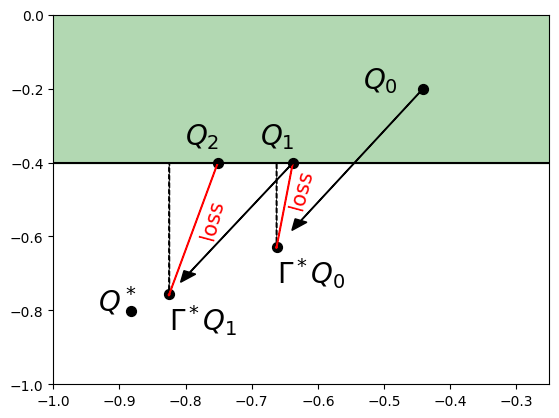

In [38]:
import matplotlib.pyplot as plt

n_points = 10
ms = np.linspace(min_m, 0, n_points)

# Optimal point
plt.scatter(env.optimal_weights[2], env.optimal_weights[0], color="black", s=50)
plt.text(-0.05 + env.optimal_weights[2], env.optimal_weights[0], "$Q^*$", fontsize=20)

# Allowed parameter space
plt.plot(ms, np.ones(n_points) * max_g, color="black")
plt.plot(ms, -np.ones(n_points) * max_g, color="black")
plt.fill_between(ms, -np.ones(n_points) * max_g, np.ones(n_points) * max_g, color="green", alpha=0.3)
plt.vlines(0, ymin=-max_g, ymax=max_g, color="black")

# Plot the first Bellman iteration and its projection
plt.scatter(initial_point[0], initial_point[1], color="black", s=50)
plt.text(-0.09 + initial_point[0], initial_point[1], "$Q_0$", fontsize=20)
x, y = initial_point[0], initial_point[1]
first_iteration = optimal_bellman_iteration(initial_point)
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx / 1.2, dy / 1.2, head_width = 0.02, color="black")

plt.scatter(first_iteration[0], first_iteration[1], color="black", s=50)
plt.text(first_iteration[0], -0.1 + first_iteration[1], f"$\Gamma^*Q_0$", fontsize=20)

first_projection = projection(first_iteration)
x, y = first_projection[0], first_projection[1]
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx, dy, color="black", linestyle="dashed")

# Plot the first iDQN point
plt.scatter(idqn_point_1[0], idqn_point_1[1], color="black", s=50)
plt.text(-0.05 + idqn_point_1[0], 0.05 + idqn_point_1[1], "$Q_1$", color="black", fontsize=20)

# Plot iDQN loss for the first point
x, y = idqn_point_1[0], idqn_point_1[1]
dx, dy = first_iteration[0] - x, first_iteration[1] - y
plt.arrow(x, y, dx, dy, color="red")
plt.text(-0.01 + idqn_point_1[0], -0.12 + idqn_point_1[1], "loss", color="red", fontsize=15, rotation=75)

# Plot the second Bellman iteration and its projection from the first iDQN point
x, y = idqn_point_1[0], idqn_point_1[1]
second_iteration = optimal_bellman_iteration(idqn_point_1)
dx, dy = second_iteration[0] - x, second_iteration[1] - y
plt.arrow(x, y, dx / 1.2, dy / 1.2, head_width = 0.02, color="black")

plt.scatter(second_iteration[0], second_iteration[1], color="black", s=50)
plt.text(second_iteration[0], -0.03 + second_iteration[0], f"$\Gamma^*Q_1$", fontsize=20)

second_projection = projection(second_iteration)
x, y = second_projection[0], second_projection[1]
dx, dy = second_iteration[0] - x, second_iteration[1] - y
plt.arrow(x, y, dx, dy, color="black", linestyle="dashed")

plt.scatter(idqn_point_2[0], idqn_point_2[1], color="black", s=50)
plt.text(-0.05 + idqn_point_2[0], 0.05 + idqn_point_2[1], "$Q_2$", color="black", fontsize=20)

# Plot iDQN loss for the second point
x, y = idqn_point_2[0], idqn_point_2[1]
dx, dy = second_iteration[0] - x, second_iteration[1] - y
plt.arrow(x, y, dx, dy, color="red")
plt.text(-0.03 + idqn_point_2[0], -0.2 + idqn_point_2[1], "loss", color="red", fontsize=15, rotation=75)

plt.xlim(-1, -0.25)
plt.ylim(-1, 0)
plt.savefig("pratical_example_idqn.pdf", bbox_inches='tight')